In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import os
import glob
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm
from scipy import interpolate
import itertools

from utils_analysis import *
from PIL import Image
import cv2

In [2]:
plt.rcParams["font.family"] = "Arial" 
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
preproceeed_data_path = "../dataset/Nakano_etal_2010/preprocessed_data"

In [4]:
embed_dim = 32
#mds_dist = np.load(f"../results/mds_dist_N2010_dim{embed_dim}.npz", allow_pickle=True)
mds_dist = np.load(f"../results/mds_dist_CW2019_drama_dim{embed_dim}.npz", allow_pickle=True)

In [5]:
mds_dist_dict = mds_dist["mds_dist"].item()
mds_dist_min_dict = mds_dist["mds_dist_min"].item()

In [6]:
training_methods = ["dino"]#["dino", "supervised"] 
depth_list = [8,12]#[8]#[4, 8, 12]
num_models = 6

In [7]:
subj_gazepos_data = np.load("../dataset/Nakano_etal_2010/preprocessed_data/goodsubj_gaze_pos.npz", allow_pickle=True)
gazepos_goodsubj = subj_gazepos_data['gaze_data_goodsubj']
gr_goodsubj = subj_gazepos_data['gr_goodsubj']
group_name = subj_gazepos_data['group_name']

In [8]:
subj_labels = ["TD adults", "TD children", "ASD adults", "ASD children"]
#subj_ecolors = np.array(["k", "k", "k", "k"])
#subj_ecolors = np.array([bright[3], bright[8], bright[4], bright[1]])
#subj_fcolors = np.array([bright[3], bright[8], bright[4], bright[1]])
#subj_ecolors = np.array(["red", "yellow", "magenta", "orange"])
subj_fcolors = np.array(["tab:red", "tab:olive", "tab:purple", "tab:orange"])
subj_ecolors = subj_fcolors
subj_markers = np.array(["o", "^", "o", "^"])

In [9]:
fps = 29.93
num_sampling = 3883
num_frames = 2327
clip_dur = 77 # sec
len_clip = 312
time = np.arange(len_clip) * clip_dur / num_sampling

In [10]:
fps =  clip_dur / num_sampling

In [11]:
1/fps

50.42857142857143

In [12]:
peak_time = np.array([8, 40, 91, 98, 231, 310])
#peak_time = np.array([11, 32, 100, 231, 310])
#peak_time = np.array([11, 32, 91, 231, 310])

In [13]:
peak_time_sample = np.floor(peak_time + 554 * num_sampling/num_frames).astype(int)
peak_time_frame = np.floor(peak_time * num_frames/num_sampling+ 554).astype(int)

In [14]:
tp = time[peak_time]

In [15]:
peak_time

array([  8,  40,  91,  98, 231, 310])

In [16]:
frame_indices = peak_time_frame #[83, 300, 645]#, 950]

In [17]:
frame_indices

array([558, 577, 608, 612, 692, 739])

In [18]:
# subj data
gazepos_subj_slice = [gazepos_goodsubj[:, frame_reidx] for frame_reidx in peak_time_sample]
#frame_reindices = [np.round((frame_idx + np.array([0,1])) * 3883 / 2327).astype(int) for frame_idx in frame_indices]
#gazepos_subj_slice = [np.nanmedian(gazepos_goodsubj[:, frame_reidx[0]:frame_reidx[1]], axis=1) for frame_reidx in frame_reindices]

#blur_imgs = [Image.open("../dataset/Nakano_etal_2010/video_stimuli/frames/frame{0:04}.png".format(frame_idx)) for frame_idx in frame_indices]
blur_imgs = [Image.open("../figures/masked_frames/frame{0:04}_masked.png".format(frame_idx)) for frame_idx in frame_indices]

In [19]:
vit_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_gaze_pos.npz", allow_pickle=True)
vit_official_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_official_gaze_pos.npz", allow_pickle=True)
gbvs_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/gbvs_gaze_pos.npz", allow_pickle=True)

In [20]:
head_GMM_label = np.load("../results/head_GMM_label.npz", allow_pickle=True)
layer_indices = head_GMM_label["layer_indices"].astype(int)
"""
label_rank = head_GMM_label["label_rank"].astype(int)
head_label = head_GMM_label["head_label"].astype(int)
head_label_proba = head_GMM_label["head_label_proba"]
num_groups = len(np.unique(label_rank))
"""
head_label = np.load("../results/attn_best_label_N2010.npy").astype(int).reshape(4, 6, 6)

In [21]:
tm = training_methods[0]
num_heads = 6
best_gaze_pos = {}
for img_idx, frame_idx in enumerate(frame_indices):
    gaze_pos = []
    for i, depth in enumerate(depth_list):
        gaze_pos_depth = vit_gaze_pos[tm].item()[str(depth)]
        d_indices = layer_indices[layer_indices[:, 0] == depth][:,1]
        for m_idx in range(num_models):
            for j, d_idx in enumerate(d_indices):
                ij = i * 2 + j
                for h_idx in range(num_heads):
                    hl = head_label[ij, m_idx, h_idx]
                    if hl == 1:
                        gaze_pos.append(gaze_pos_depth[m_idx, d_idx, h_idx, frame_idx])
    best_gaze_pos[str(frame_idx)] = np.stack(gaze_pos)

In [22]:
patch_size = 16
sigma = patch_size/6

In [23]:
x, y = [], []
for img_idx, frame_idx in enumerate(frame_indices):
    gr_idx = 0
    gr_slice = gr_goodsubj == gr_idx
    x.append(gazepos_subj_slice[img_idx][gr_slice,0])
    y.append(gazepos_subj_slice[img_idx][gr_slice,1])

In [24]:
x2, y2 = [], []
depth = 8
for img_idx, frame_idx in enumerate(frame_indices):
    best_gaze_pos_depth = best_gaze_pos[str(frame_idx)]
    best_gaze_pos_depth += np.random.randn(len(best_gaze_pos_depth), 2) * sigma
    gp = best_gaze_pos_depth.reshape(-1, 2)
    x2.append(gp[:, 0])
    y2.append(gp[:, 1])

In [25]:
"""
x3, y3 = [], []
depth = 12
for img_idx, frame_idx in enumerate(frame_indices):
    best_gaze_pos_depth = best_gaze_pos[str(frame_idx)][tm][str(depth)]
    best_gaze_pos_depth += np.random.randn(num_models, num_top, 2) * sigma
    gp = best_gaze_pos_depth.reshape(-1, 2)
    x3.append(gp[:, 0])
    y3.append(gp[:, 1])
"""

'\nx3, y3 = [], []\ndepth = 12\nfor img_idx, frame_idx in enumerate(frame_indices):\n    best_gaze_pos_depth = best_gaze_pos[str(frame_idx)][tm][str(depth)]\n    best_gaze_pos_depth += np.random.randn(num_models, num_top, 2) * sigma\n    gp = best_gaze_pos_depth.reshape(-1, 2)\n    x3.append(gp[:, 0])\n    y3.append(gp[:, 1])\n'

DINo ViT 8を同時に出すか

In [26]:
from scipy.stats import gaussian_kde

In [27]:
def plot_scatter_density(x, y, ax, cmap, marker, s, alpha):
    # Calculate the point density
    nan_idx = np.isnan(x) | np.isnan(y)
    x = x[~nan_idx]
    y = y[~nan_idx]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    ax.scatter(x, y, c=z, cmap=cmap, marker=marker, s=s, alpha=alpha, rasterized=True)

In [28]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap_base = 'jet'
vmin, vmax = 0.2, 0.8
cmap = truncate_colormap(cmap_base, vmin, vmax)

In [29]:
cmap = mpl.colormaps.get_cmap('autumn')

In [30]:
#cmap2 = truncate_colormap('coolwarm', 0.5, 0)
#cmap3 = truncate_colormap('coolwarm', 0.5, 1)

In [31]:
def im2gray(im):
    if im.mode != "RGB":
        im = im.convert("RGB") # any format to RGB
    rgb = np.array(im, dtype="float32");
    
    rgbL = pow(rgb/255.0, 2.2)
    r, g, b = rgbL[:,:,0], rgbL[:,:,1], rgbL[:,:,2]
    grayL = 0.299 * r + 0.587 * g + 0.114 * b  # BT.601
    gray = pow(grayL, 1.0/2.2)*255
    
    im_gray = Image.fromarray(gray.astype("uint8"))
    return im_gray

In [32]:
blur_imgs_gray = [im2gray(im) for im in blur_imgs]

/tmp/ipykernel_3223/869694705.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("../figures/gaze_points_examples_viewing.svg", bbox_inches='tight', dpi=200)


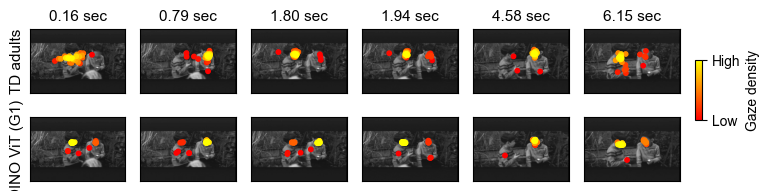

In [51]:
num_frame = len(frame_indices)
fig, axes = plt.subplots(2, len(frame_indices), figsize=(7, 3), tight_layout=True)
for img_idx, frame_idx in enumerate(frame_indices):
    for i in range(2):
        axes[i, img_idx].imshow(blur_imgs_gray[img_idx], cmap="gray")
        #axes[i, img_idx].imshow(blur_imgs[img_idx])
        axes[i, img_idx].set_xticks([])
        axes[i, img_idx].set_yticks([])
        #axes[i, img_idx].set_xlim(100, 620)
        #axes[i, img_idx].set_ylim(380, 100)
        #axes[0, img_idx].scatter(x[img_idx], y[img_idx], color="tab:red", marker="o", alpha=0.1, rasterized=True)
        #axes[1, img_idx].scatter(x2[img_idx], y2[img_idx], color="tab:blue", marker="o", alpha=0.1, rasterized=True)
    plot_scatter_density(x[img_idx], y[img_idx], axes[0, img_idx], cmap=cmap, marker="o", s=10, alpha=1)
    plot_scatter_density(x2[img_idx], y2[img_idx], axes[1, img_idx], cmap=cmap, marker="o", s=10, alpha=1)
    #plot_scatter_density(x3[img_idx], y3[img_idx], axes[2, img_idx], cmap=cmap, marker="o", s=10, alpha=1)
        #plt.setp(axes[i, img_idx].spines.values(), lw=1.5, color=cmap(img_idx/(num_frame-1)), alpha=1);
    axes[0, img_idx].set_title(f"{tp[img_idx]:.02f} sec", fontsize=11)
axes[0, 0].set_ylabel("TD adults", fontsize=11)
axes[1, 0].set_ylabel("DINO ViT (G1)", fontsize=11)
#axes[2, 0].set_ylabel("DINO ViT-12", fontsize=11)
cax = plt.axes([1, 0.45, 0.01, 0.2])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=cmap),
             cax=cax, orientation='vertical', label='Gaze density', ticks=[0, 1]) #'# blocks / total blocks')
cb.ax.set_yticklabels(['Low', 'High']) 
fig.savefig("../figures/gaze_points_examples_viewing.svg", bbox_inches='tight', dpi=200)